In [ ]:
!pip install geopandas
!pip install contextily
!pip install plotly.express
!pip install --upgrade nbformat
!pip install missingno
!pip install statsmodels

# TP Análisis de datos - Parte 1

#### Integrantes:
* Daniela Putrino
* Dimas Torres

El objetivo de este trabajo es realizar un **análisis exploratorio de datos (EDA)** completo sobre un conjunto de registros extraidos de la web del Servicio Meteorológico Nacional (SMN) Argentino.

El dataset se conforma con dos archivos descargados y unidos convenientemente:
1. DatoHorario: consta de valores por hora para las *features*
    * Temperatura (TEMP)
    * Humedad (HUM)
    * Presión Normal Media (PNM)    
    * DD
    * FF
3. EstacionesSMN: información sobre la localización de las distintas estaciones meteorológicas (latitud, longitud, altitud y provincia).

Luego, con el dataframe limpio se podrá implementar (a futuro) un modelo de machine learning supervisado de regresión para predecir la temperatura (variable target, *y*) a cada hora, por estación, a partir de las otras variables climáticas y geográficas disponibles.

In [112]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import missingno as msno
import statsmodels.api as sm

In [180]:
# Definimos la ruta de los datos
path = "SMN_data/"
# Cargamos el archivo de datos horarios
# Debemos utilizar el función read_fwf para leer archivos de ancho fijo, separando por tabulaciones
# Omitimos las dos primeras filas y definimos los nombres de las columnas, con sus respectivas unidades.
# Definimos el encoding como 'latin1' para evitar problemas con caracteres especiales.
df_hor = pd.read_fwf(path+"datohorario20250715.txt", encoding='latin1', sep='\t', skiprows=2, names=["FECHA (ddmmyyyy)", "HORA", "TEMP (°C)", "HUM (%)", "PNM (hPa)", "DD (g)", "FF (km/h)", "ESTACION"])

df_hor.head()  # Mostramos las primeras filas del DataFrame para verificar que se ha cargado correctamente

,FECHA (ddmmyyyy),HORA,TEMP (°C),HUM (%),PNM (hPa),DD (g),FF (km/h),ESTACION
0,15072025.0,0.0,13.7,88.0,1020.2,80.0,13.0,AEROPARQUE AERO
1,15072025.0,1.0,13.6,91.0,1019.6,80.0,11.0,AEROPARQUE AERO
2,15072025.0,2.0,13.4,91.0,1019.3,80.0,11.0,AEROPARQUE AERO
3,15072025.0,3.0,13.4,94.0,1018.7,80.0,13.0,AEROPARQUE AERO
4,15072025.0,4.0,13.7,91.0,1018.2,90.0,9.0,AEROPARQUE AERO


In [181]:
# Analizamos los tipos de datos
df_hor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074 entries, 0 to 2073
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FECHA (ddmmyyyy)  2035 non-null   float64
 1   HORA              2035 non-null   float64
 2   TEMP (°C)         2035 non-null   float64
 3   HUM (%)           2035 non-null   float64
 4   PNM (hPa)         1828 non-null   float64
 5   DD (g)            2034 non-null   float64
 6   FF (km/h)         2034 non-null   float64
 7   ESTACION          2074 non-null   object 
dtypes: float64(7), object(1)
memory usage: 129.8+ KB


In [182]:
df_hor.shape  # Verificamos la forma del DataFrame

(2074, 8)

In [183]:
# Convertimos las columnas a los tipos de datos adecuados
# OBS: Necesitamos convertir los datos a tipos que soporten valores nulos; se identifican con mayúscula inicial
df_hor['FECHA (ddmmyyyy)'] = pd.to_datetime(df_hor['FECHA (ddmmyyyy)'], format='%d%m%Y') # Convertir a tipo fecha, aunque no tiene sentido ya que no utilizaremos esta columna por tener un único valor; son todos datos del mismo día.
df_hor["HORA"] = df_hor["HORA"].astype("Int64")
df_hor["TEMP (°C)"] = df_hor["TEMP (°C)"].astype("Float64")
df_hor["HUM (%)"] = df_hor["HUM (%)"].astype("Int64")
df_hor["DD (g)"] = df_hor["DD (g)"].astype("Int64")
df_hor["FF (km/h)"] = df_hor["FF (km/h)"].astype("Int64")

df_hor.info()  # Verificamos que los tipos de datos se han actualizado correctamente

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074 entries, 0 to 2073
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA (ddmmyyyy)  2035 non-null   datetime64[ns]
 1   HORA              2035 non-null   Int64         
 2   TEMP (°C)         2035 non-null   Float64       
 3   HUM (%)           2035 non-null   Int64         
 4   PNM (hPa)         1828 non-null   float64       
 5   DD (g)            2034 non-null   Int64         
 6   FF (km/h)         2034 non-null   Int64         
 7   ESTACION          2074 non-null   object        
dtypes: Float64(1), Int64(4), datetime64[ns](1), float64(1), object(1)
memory usage: 139.9+ KB


In [184]:
df_hor.head()  # Mostramos nuevamente las primeras filas para ver los cambios realizados

,FECHA (ddmmyyyy),HORA,TEMP (°C),HUM (%),PNM (hPa),DD (g),FF (km/h),ESTACION
0,2025-07-15,0,13.7,88,1020.2,80,13,AEROPARQUE AERO
1,2025-07-15,1,13.6,91,1019.6,80,11,AEROPARQUE AERO
2,2025-07-15,2,13.4,91,1019.3,80,11,AEROPARQUE AERO
3,2025-07-15,3,13.4,94,1018.7,80,13,AEROPARQUE AERO
4,2025-07-15,4,13.7,91,1018.2,90,9,AEROPARQUE AERO


## Análisis de datos faltantes

In [185]:
df_hor.isna().mean().round(4)*100

FECHA (ddmmyyyy)     1.88
HORA                 1.88
TEMP (°C)            1.88
HUM (%)              1.88
PNM (hPa)           11.86
DD (g)               1.93
FF (km/h)            1.93
ESTACION             0.00
dtype: float64

<Axes: >

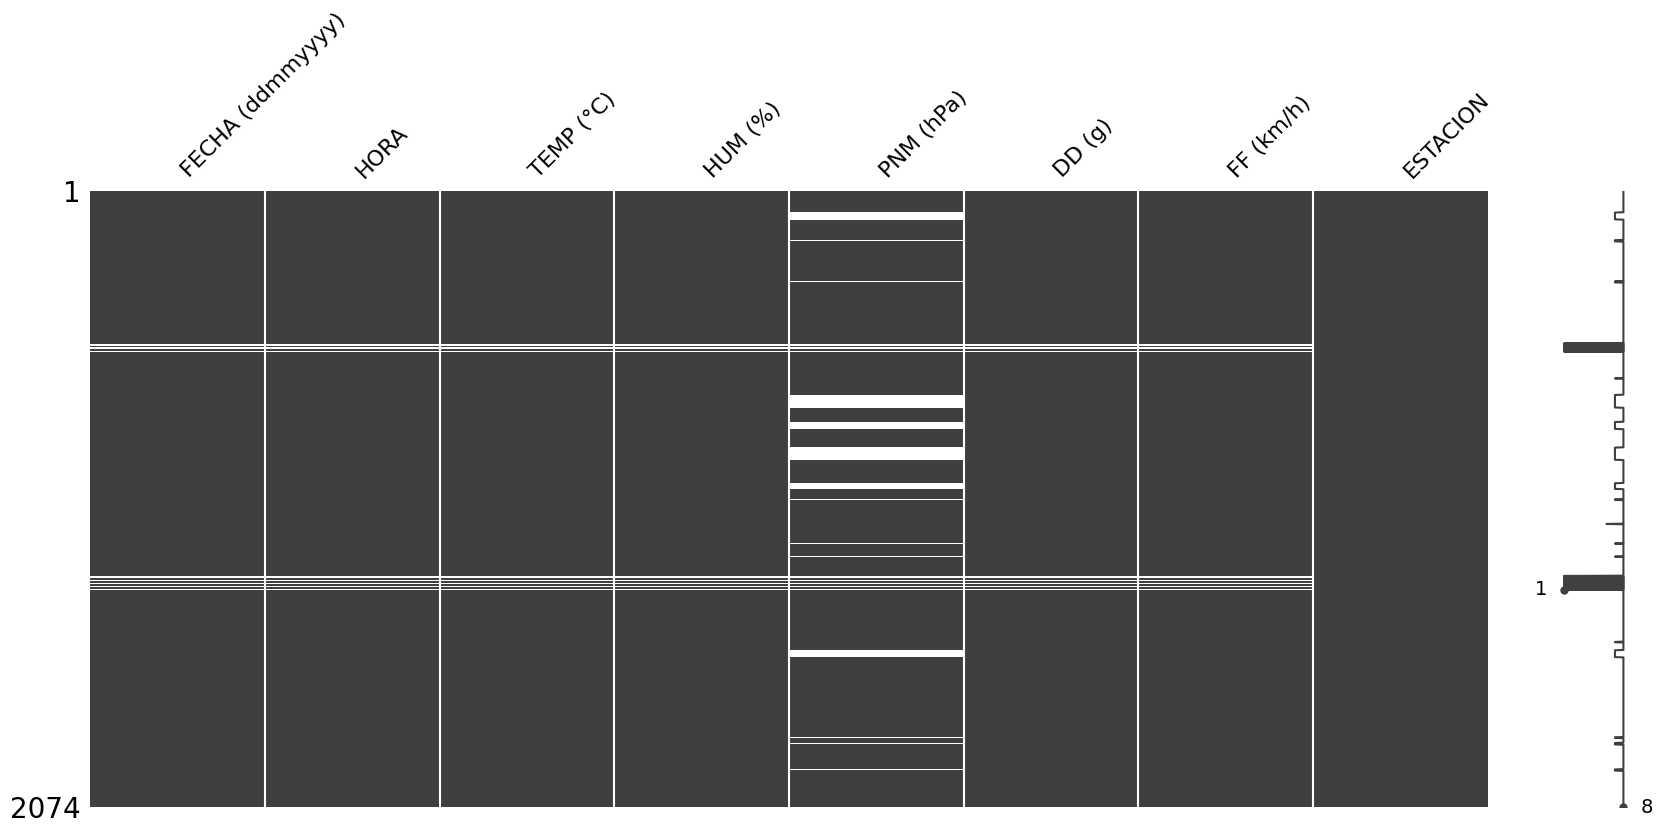

In [186]:
# Matriz de valores faltantes
msno.matrix(df_hor, figsize=(20,8))

Podemos ver que hay algunas filas que tienen valores nulos en todas las columnas salvo en estación, así que vamos a generar una lógica para eliminar estos registros dado que probablemente para esas estaciones estuviera caída la recolección de datos y, por consiguiente no se tiene info para predecir la T en el día de la fecha.

In [187]:
columnas_a_revisar = [col for col in df_hor.columns if col != 'ESTACION']

# Paso 2: Aplicar .dropna() con how='all'
df_hor = df_hor.dropna(subset=columnas_a_revisar, how='all')
df_hor.reset_index(drop=True, inplace=True)  # Reseteamos el índice del DataFrame
df_hor.shape  # Verificamos la forma del DataFrame después de eliminar filas

(2035, 8)

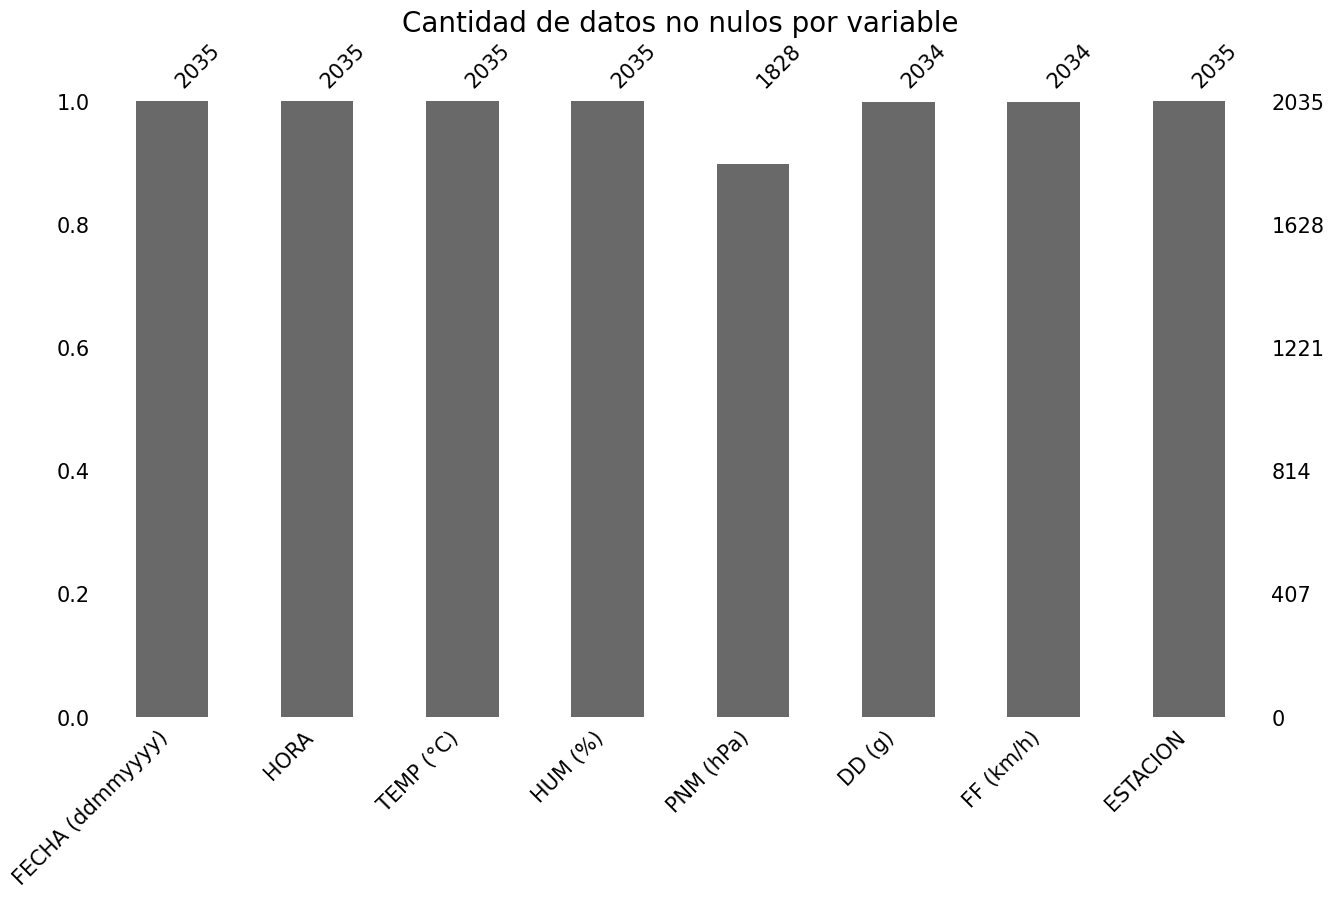

In [188]:
msno.bar(df_hor, fontsize=15, figsize=(15,8))
plt.title("Cantidad de datos no nulos por variable", fontsize=20)
plt.show()

<Axes: >

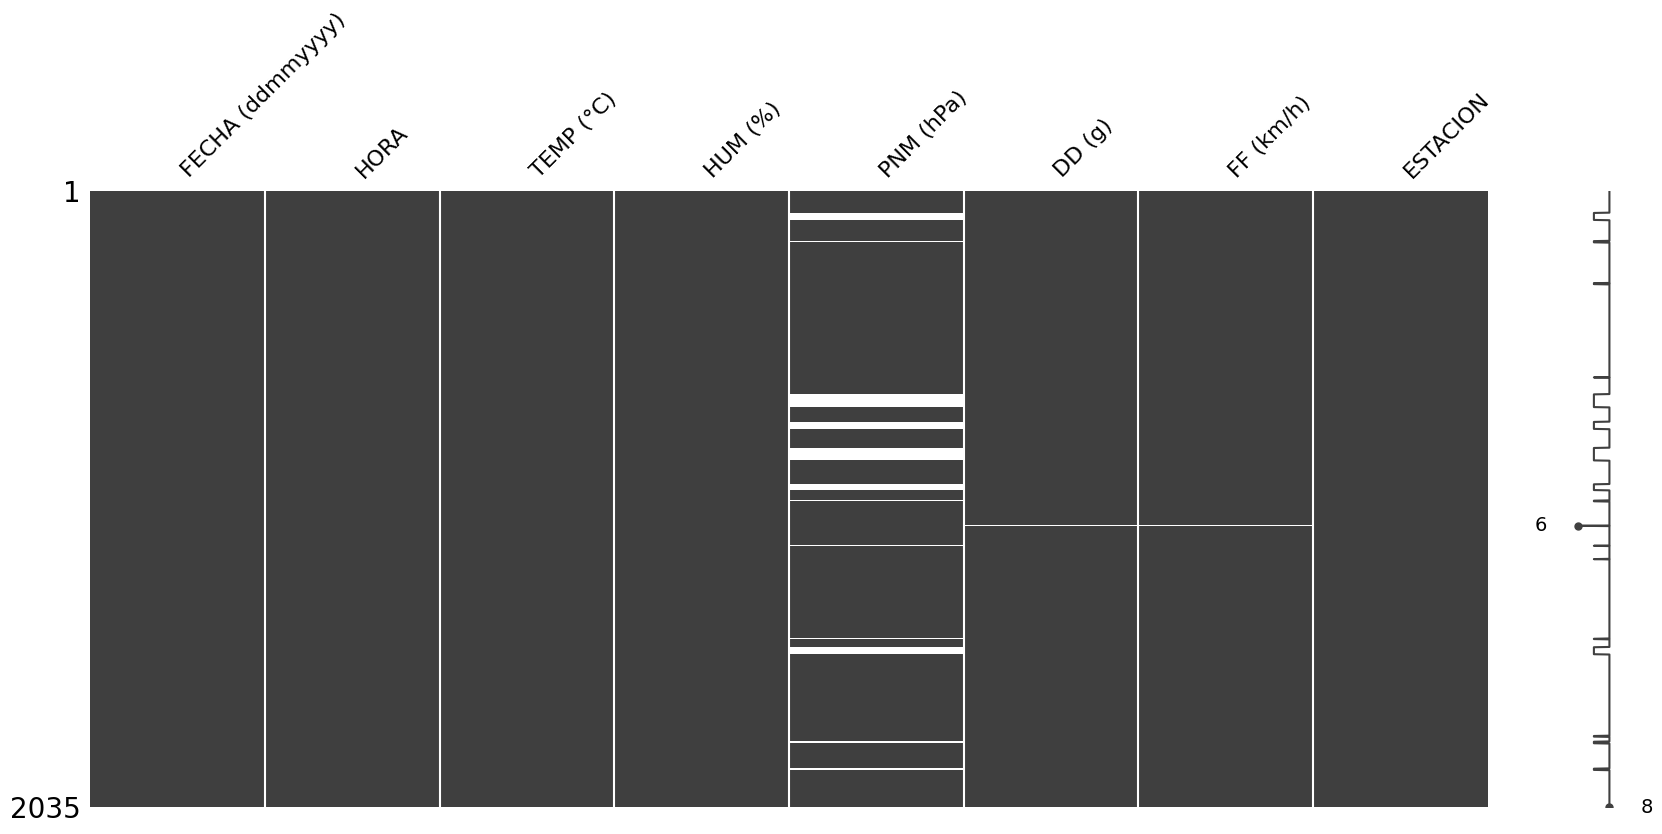

In [189]:
# Matriz de valores faltantes
msno.matrix(df_hor, figsize=(20,8))

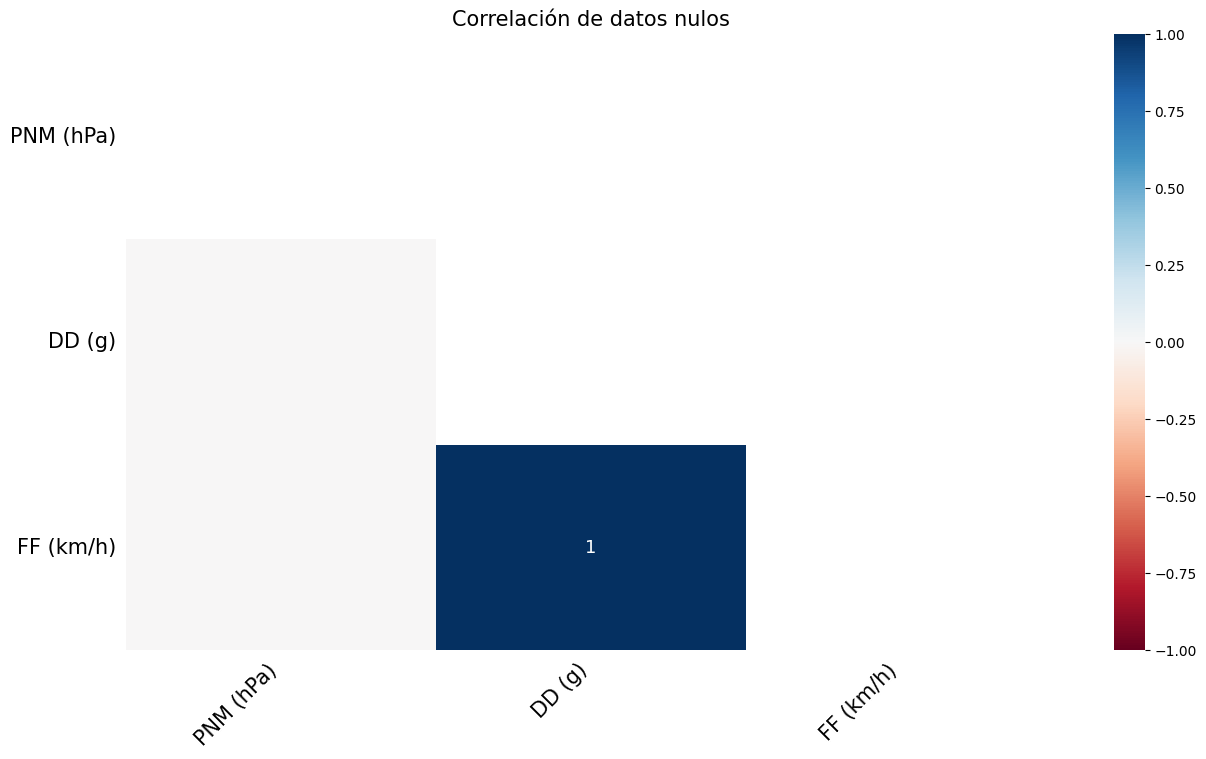

In [190]:
msno.heatmap(df_hor, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

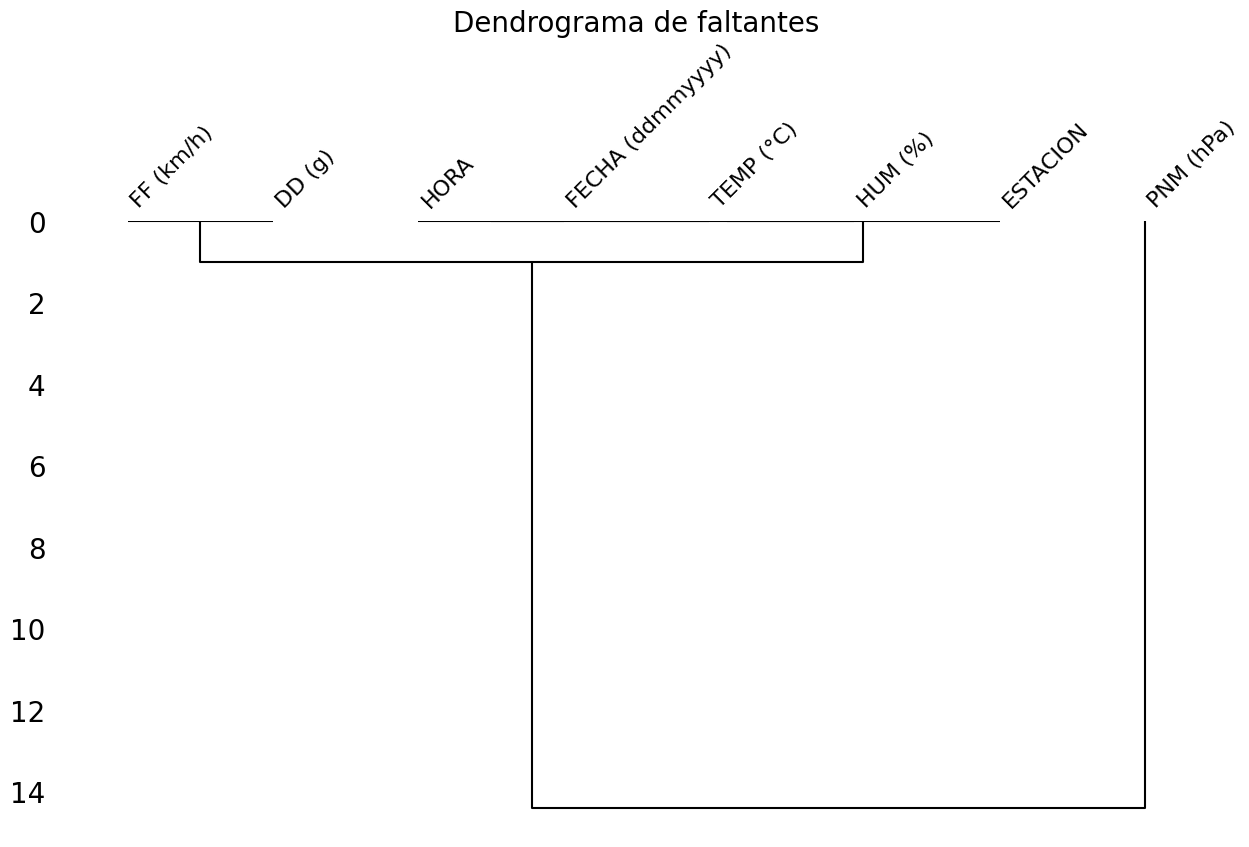

In [191]:
msno.dendrogram(df_hor, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

Se observa que hay correlación perfecta en el registro que falta el dato para DD y también para FF

## Análisis de variables numéricas

<Axes: xlabel='HORA'>

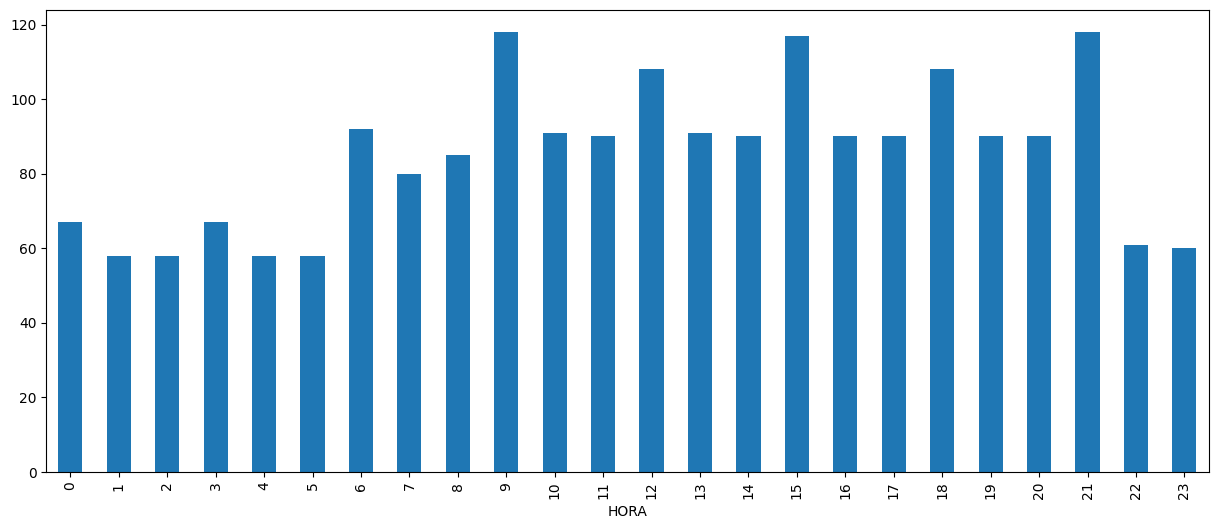

In [201]:
df_hor.HORA.value_counts().sort_index().plot(kind='bar', figsize=(15, 6))

No hay outliers en Hora, pero sí hay más faltantes en determinados momentos del día

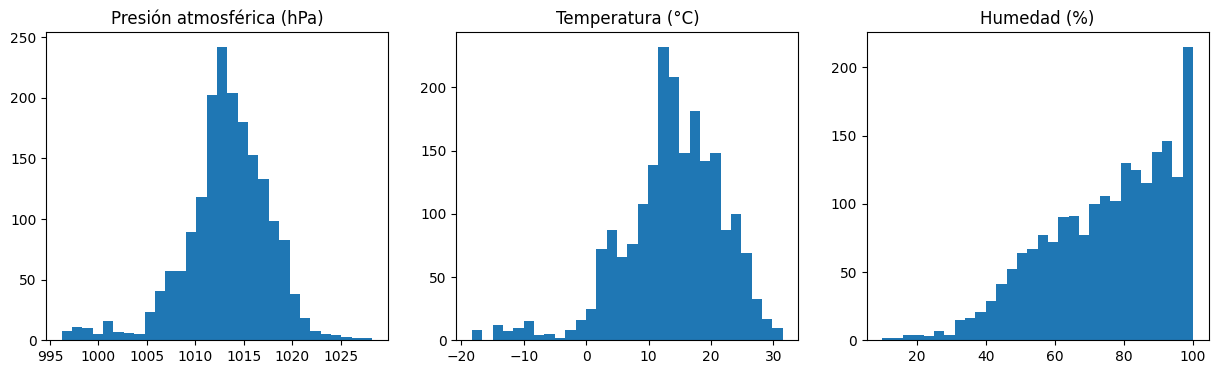

In [204]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].hist(df_hor["PNM (hPa)"], bins=30)   
ax[0].set_title('Presión atmosférica (hPa)')
ax[1].hist(df_hor["TEMP (°C)"], bins=30)  
ax[1].set_title('Temperatura (°C)')
ax[2].hist(df_hor["HUM (%)"], bins=30)
ax[2].set_title('Humedad (%)')

plt.show()

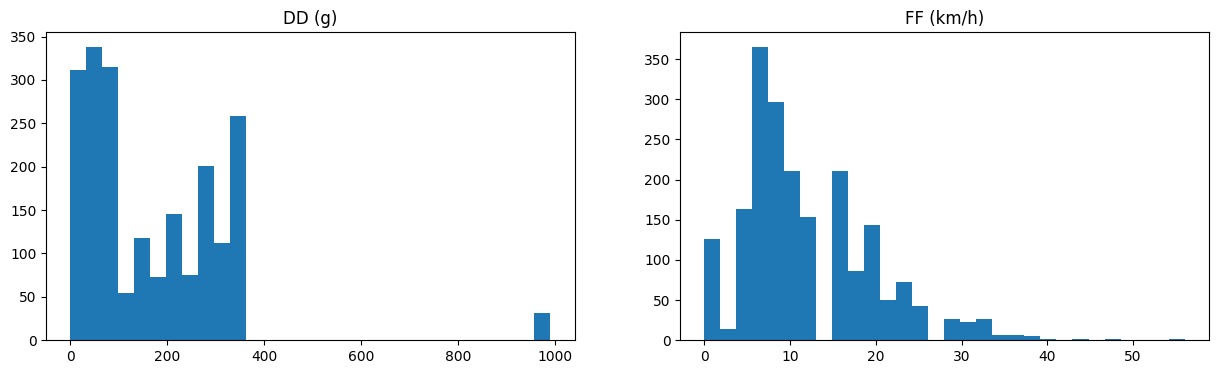

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(df_hor["DD (g)"], bins=30)   
ax[0].set_title('DD (g)')
ax[1].hist(df_hor["FF (km/h)"], bins=30)  
ax[1].set_title('FF (km/h)')

plt.show()

Hay un valor muy atípico en DD, a revisar

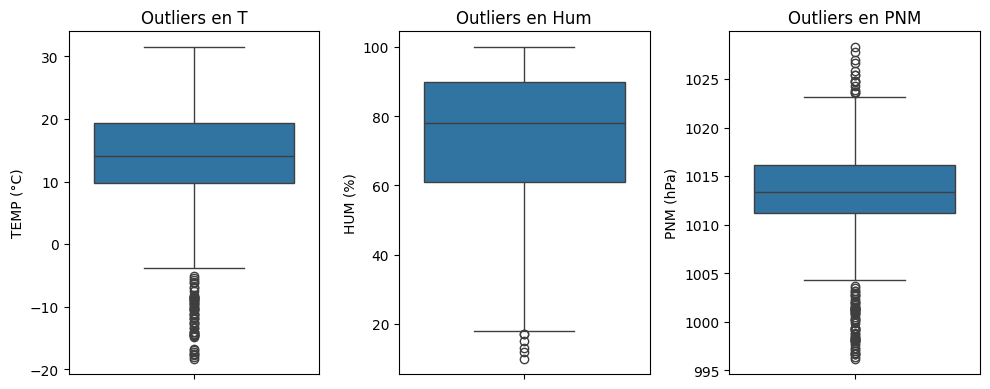

In [210]:
# Visualización de outliers con boxplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Boxplot para 'Temperatura'
sns.boxplot(y=df_hor["TEMP (°C)"], ax=axes[0])
axes[0].set_title('Outliers en T')

# Boxplot para 'Humidad'
sns.boxplot(y=df_hor["HUM (%)"], ax=axes[1])
axes[1].set_title('Outliers en Hum')

# Boxplot para 'PNM'
sns.boxplot(y=df_hor["PNM (hPa)"], ax=axes[2])
axes[2].set_title('Outliers en PNM')

plt.tight_layout()
plt.show()

Presión atmosférica presenta mayor dispersión, analizaremos valores posibles de la variable

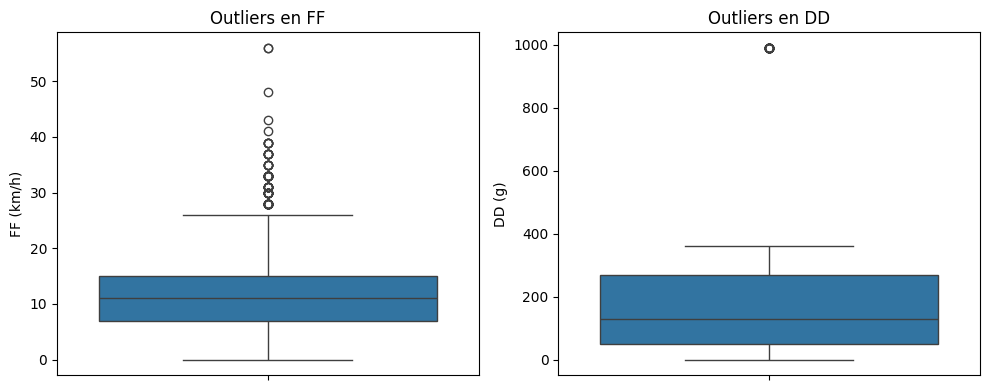

In [192]:
# Visualización de outliers con boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Boxplot para 'FF'
sns.boxplot(y=df_hor["FF (km/h)"], ax=axes[0])
axes[0].set_title('Outliers en FF')

# Boxplot para 'DD'
sns.boxplot(y=df_hor["DD (g)"], ax=axes[1])
axes[1].set_title('Outliers en DD')

plt.tight_layout()
plt.show()

<Axes: ylabel='FF (km/h)'>

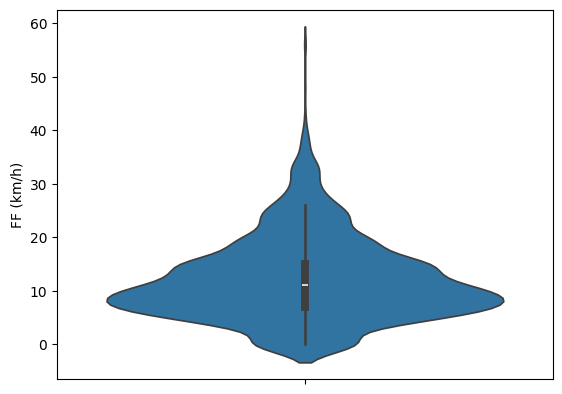

In [193]:
sns.violinplot(y=df_hor["FF (km/h)"])

## Análisis de correlación entre variables

Observamos la distribución de todas las variables numéricas y la correlación de a pares

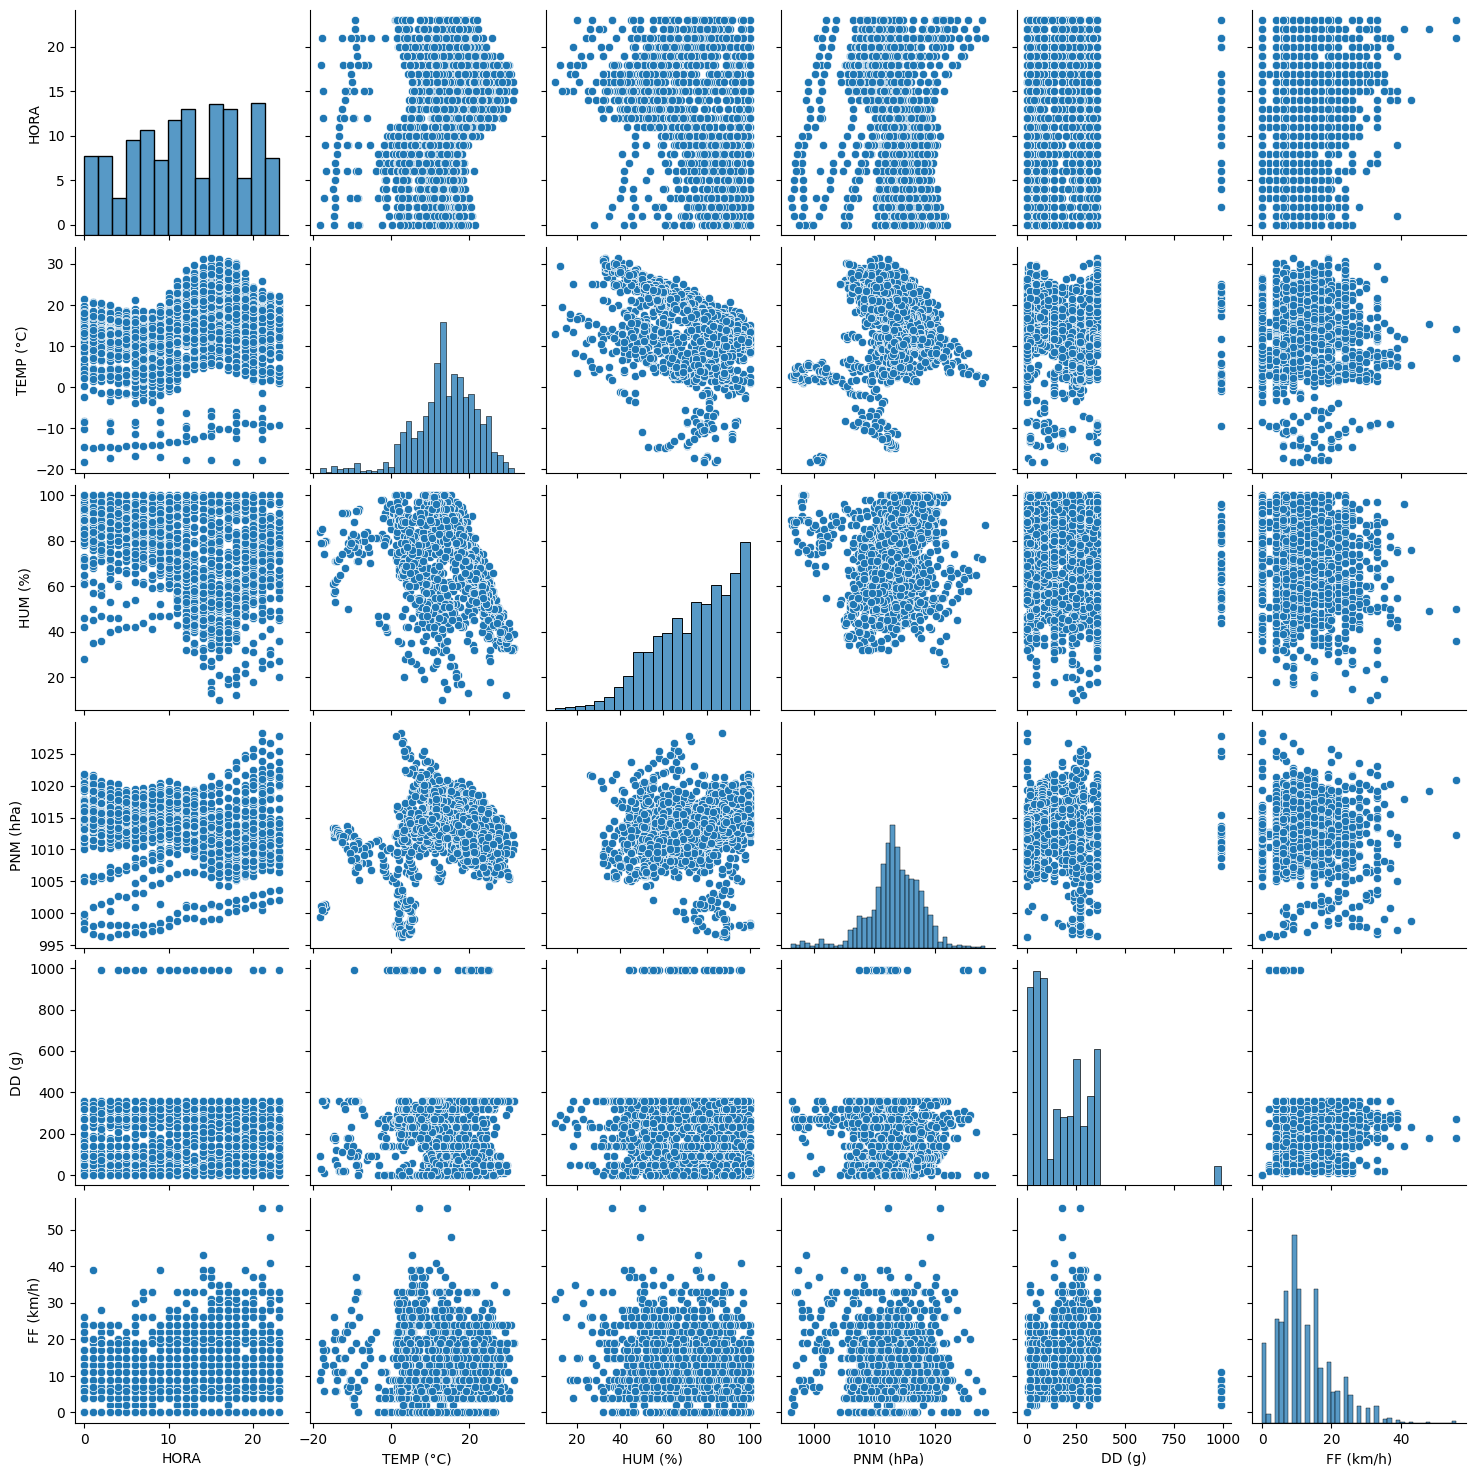

In [211]:
sns.pairplot(data=df_hor)
plt.show()

Hay algunos casos extremos a analizar:
1. Valores altos de DD para todas las variables

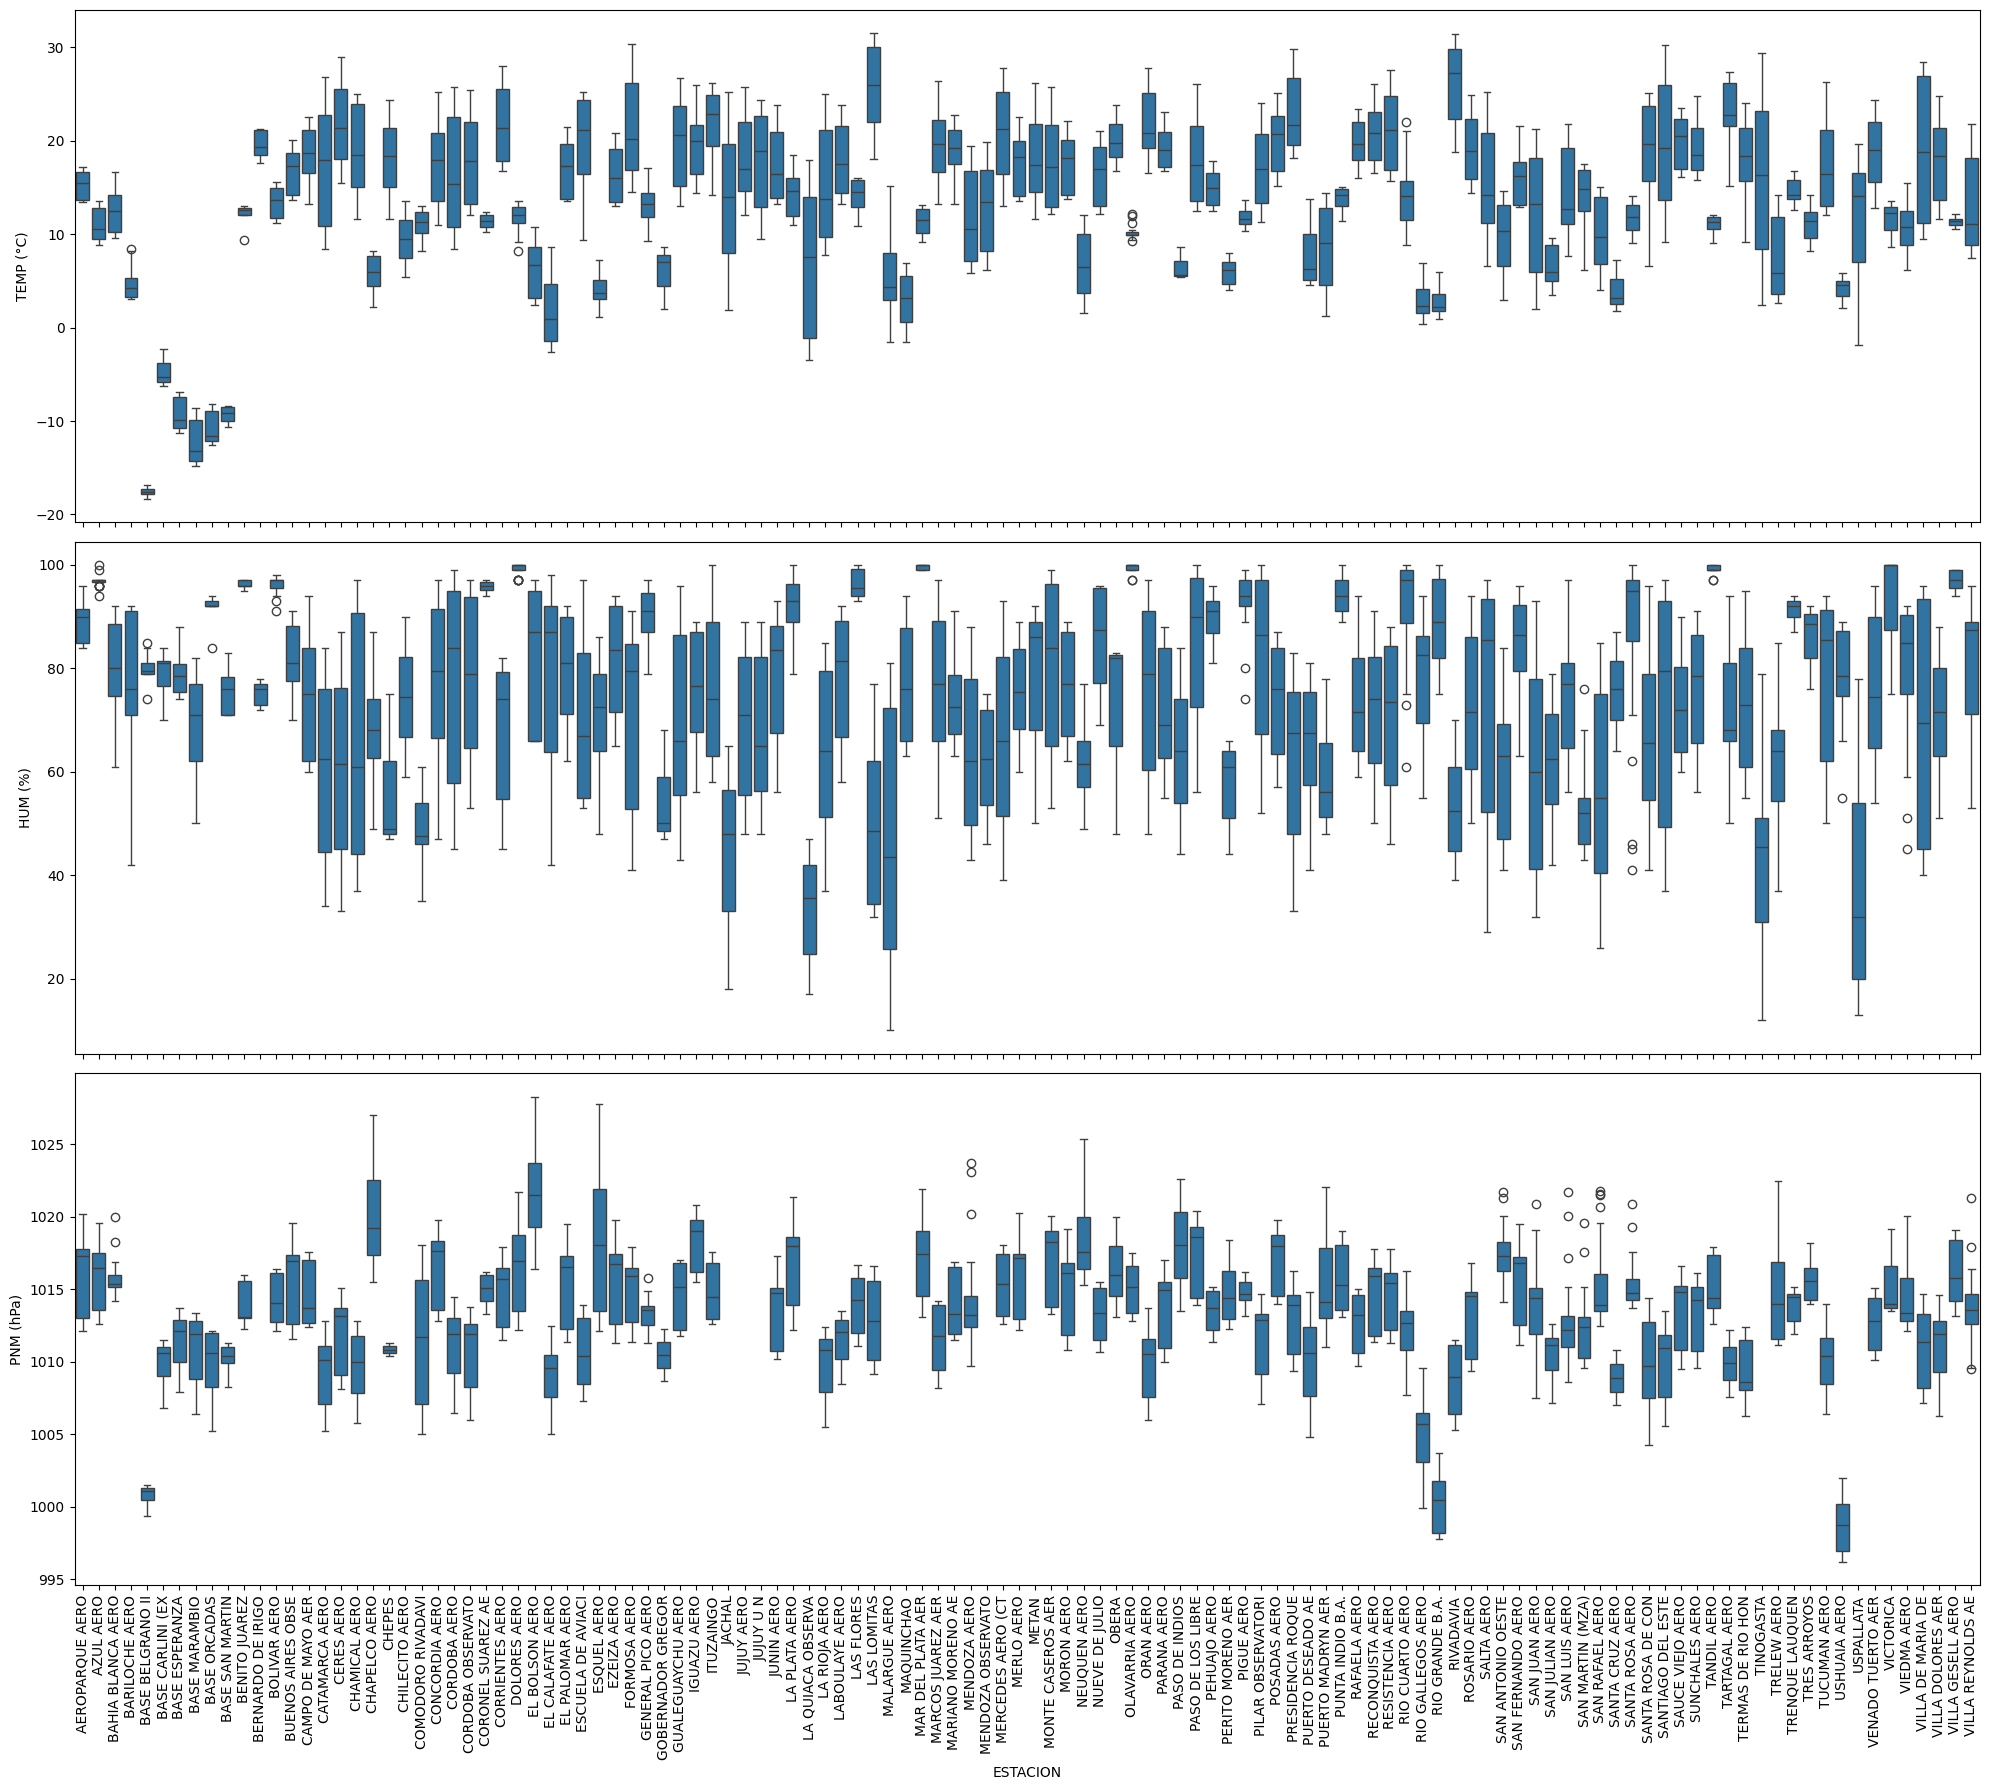

In [224]:
fig, ax = plt.subplots(3, 1,figsize=(20, 18), sharex=True)

sns.boxplot(data=df_hor, y='TEMP (°C)', x='ESTACION', ax=ax[0])
sns.boxplot(data=df_hor, y='HUM (%)', x='ESTACION', ax=ax[1])
sns.boxplot(data=df_hor, y='PNM (hPa)', x='ESTACION', ax=ax[2])

plt.setp(ax[2].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [196]:
df_hor.groupby("ESTACION")["TEMP (°C)"].agg(["min", "max", "mean"])  # Agrupamos por estación y calculamos las estadísticas de temperatura

,min,max,mean
ESTACION,,,
AEROPARQUE AERO,13.4,17.2,15.2375
AZUL AERO,8.8,13.6,10.9875
BAHIA BLANCA AERO,9.6,16.7,12.625
BARILOCHE AERO,3.1,8.4,4.654167
BASE BELGRANO II,-18.3,-16.8,-17.55
...,...,...,...
VIEDMA AERO,6.2,15.5,10.7
VILLA DE MARIA DE,9.5,28.4,18.994444
VILLA DOLORES AER,11.6,24.8,17.879167


In [125]:
# Cargamos el archivo de datos de estaciones
df_est = pd.read_fwf(path+"estaciones_smn.txt", encoding='latin1', sep='\t', skiprows=2, names=["ESTACION", "PROVINCIA", "LAT_GRAD", "LAT_MIN", "LON_GRAD", "LON_MIN", "ALTURA", "NUM", "NroOACI"])
df_est

,ESTACION,PROVINCIA,LAT_GRAD,LAT_MIN,LON_GRAD,LON_MIN,ALTURA,NUM,NroOACI
0,BASE BELGRANO II,ANTARTIDA,-77.0,52.0,-34.0,37.0,256.0,89034.0,SAYB
1,BASE CARLINI (EX JUBANY),ANTARTIDA,-62.0,14.0,-58.0,39.0,11.0,89053.0,SAYJ
2,BASE ESPERANZA,ANTARTIDA,-63.0,23.0,-56.0,59.0,24.0,88963.0,SAYE
3,BASE MARAMBIO,ANTARTIDA,-64.0,14.0,-56.0,37.0,198.0,89055.0,SAWB
4,BASE ORCADAS,ANTARTIDA,-60.0,44.0,-44.0,44.0,12.0,88968.0,SAYO
...,...,...,...,...,...,...,...,...,...
115,SANTIAGO DEL ESTERO AERO,SANTIAGO DEL ES,-27.0,45.0,-64.0,17.0,199.0,87129.0,SANE
116,TERMAS DE RIO HONDO AERO,SANTIAGO DEL ES,-27.0,30.0,-64.0,56.0,280.0,87127.0,SANR
117,RIO GRANDE B.A.,TIERRA DEL FUEG,-53.0,46.0,-67.0,45.0,22.0,87934.0,SAWE
118,USHUAIA AERO,TIERRA DEL FUEG,-54.0,50.0,-68.0,18.0,57.0,87938.0,SAWH


In [126]:
# Generamos las coordenadas de latitud y longitud a partir de los grados y minutos. Debemos contemplar  el signo de modo de obtener la conversión correcta.
df_est['LAT'] = (df_est['LAT_GRAD'] - df_est['LAT_MIN'] / 60)
df_est['LON'] = (df_est['LON_GRAD'] - df_est['LON_MIN'] / 60)

In [127]:
df_est.isna().mean().round(4)*100

ESTACION     0.00
PROVINCIA    1.67
LAT_GRAD     1.67
LAT_MIN      1.67
LON_GRAD     1.67
LON_MIN      1.67
ALTURA       1.67
NUM          1.67
NroOACI      2.50
LAT          1.67
LON          1.67
dtype: float64

In [128]:
df_est.isna().index

RangeIndex(start=0, stop=120, step=1)

In [129]:
# Unimos los DataFrames de datos horarios y estaciones por la columna 'ESTACION'
# Utilizamos un merge externo para conservar todas las estaciones, incluso si no tienen datos horarios
# --- esto último lo verificaremos más adelante ---
df_combinado = pd.merge(df_hor, df_est, on='ESTACION', how='outer')
df_combinado

,FECHA (ddmmyyyy),HORA,TEMP (°C),HUM (%),PNM (hPa),DD (g),FF (km/h),ESTACION,PROVINCIA,LAT_GRAD,LAT_MIN,LON_GRAD,LON_MIN,ALTURA,NUM,NroOACI,LAT,LON
0,2025-07-15,0,13.7,88,1020.2,80,13,AEROPARQUE AERO,CAPITAL FEDERAL,-34.0,33.0,-58.0,25.0,6.0,87582.0,SABE,-34.550000,-58.416667
1,2025-07-15,1,13.6,91,1019.6,80,11,AEROPARQUE AERO,CAPITAL FEDERAL,-34.0,33.0,-58.0,25.0,6.0,87582.0,SABE,-34.550000,-58.416667
2,2025-07-15,2,13.4,91,1019.3,80,11,AEROPARQUE AERO,CAPITAL FEDERAL,-34.0,33.0,-58.0,25.0,6.0,87582.0,SABE,-34.550000,-58.416667
3,2025-07-15,3,13.4,94,1018.7,80,13,AEROPARQUE AERO,CAPITAL FEDERAL,-34.0,33.0,-58.0,25.0,6.0,87582.0,SABE,-34.550000,-58.416667
4,2025-07-15,4,13.7,91,1018.2,90,9,AEROPARQUE AERO,CAPITAL FEDERAL,-34.0,33.0,-58.0,25.0,6.0,87582.0,SABE,-34.550000,-58.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,2025-07-15,20,14.8,83,1015.8,180,19,VILLA REYNOLDS AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2063,2025-07-15,21,14.0,89,1016.4,180,17,VILLA REYNOLDS AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2064,2025-07-15,22,11.6,96,1017.9,140,41,VILLA REYNOLDS AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,2025-07-15,23,7.4,88,1021.3,180,19,VILLA REYNOLDS AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# Obtenemos el dataframe que utilizaríamos para el modelado, eliminando las columnas que no aportan información o que presentan correlación muy alta con otras
df_ok = df_combinado.drop(columns=["FECHA (ddmmyyyy)", "ESTACION", "LAT_GRAD", "LAT_MIN", "LON_GRAD", "LON_MIN", "NUM", "NroOACI"])
df_ok

,HORA,TEMP (°C),HUM (%),PNM (hPa),DD (g),FF (km/h),PROVINCIA,ALTURA,LAT,LON
0,0,13.7,88,1020.2,80,13,CAPITAL FEDERAL,6.0,-34.550000,-58.416667
1,1,13.6,91,1019.6,80,11,CAPITAL FEDERAL,6.0,-34.550000,-58.416667
2,2,13.4,91,1019.3,80,11,CAPITAL FEDERAL,6.0,-34.550000,-58.416667
3,3,13.4,94,1018.7,80,13,CAPITAL FEDERAL,6.0,-34.550000,-58.416667
4,4,13.7,91,1018.2,90,9,CAPITAL FEDERAL,6.0,-34.550000,-58.416667
...,...,...,...,...,...,...,...,...,...,...
2062,20,14.8,83,1015.8,180,19,NaN,NaN,NaN,NaN
2063,21,14.0,89,1016.4,180,17,NaN,NaN,NaN,NaN
2064,22,11.6,96,1017.9,140,41,NaN,NaN,NaN,NaN
2065,23,7.4,88,1021.3,180,19,NaN,NaN,NaN,NaN


In [131]:
# Creamos features para la hora, para que se interpreten los ciclos diarios
df_ok['HORA_sen'] = np.sin(2 * np.pi * df_ok['HORA']/24.0)
df_ok['HORA_cos'] = np.cos(2 * np.pi * df_ok['HORA']/24.0)

In [132]:
df_ok.drop("HORA", axis=1, inplace=True)  # Eliminamos la columna HORA original, ya que no la utilizaremos

In [133]:
df_ok

,TEMP (°C),HUM (%),PNM (hPa),DD (g),FF (km/h),PROVINCIA,ALTURA,LAT,LON,HORA_sen,HORA_cos
0,13.7,88,1020.2,80,13,CAPITAL FEDERAL,6.0,-34.550000,-58.416667,0.0,1.0
1,13.6,91,1019.6,80,11,CAPITAL FEDERAL,6.0,-34.550000,-58.416667,0.258819,0.965926
2,13.4,91,1019.3,80,11,CAPITAL FEDERAL,6.0,-34.550000,-58.416667,0.5,0.866025
3,13.4,94,1018.7,80,13,CAPITAL FEDERAL,6.0,-34.550000,-58.416667,0.707107,0.707107
4,13.7,91,1018.2,90,9,CAPITAL FEDERAL,6.0,-34.550000,-58.416667,0.866025,0.5
...,...,...,...,...,...,...,...,...,...,...,...
2062,14.8,83,1015.8,180,19,NaN,NaN,NaN,NaN,-0.866025,0.5
2063,14.0,89,1016.4,180,17,NaN,NaN,NaN,NaN,-0.707107,0.707107
2064,11.6,96,1017.9,140,41,NaN,NaN,NaN,NaN,-0.5,0.866025
2065,7.4,88,1021.3,180,19,NaN,NaN,NaN,NaN,-0.258819,0.965926


## Encoding de variable categórica

In [134]:
df_ok = pd.get_dummies(df_ok, columns=['PROVINCIA'], prefix='PROV', drop_first=True)  # Convertimos la columna PROVINCIA en variables dummy, eliminando la primera para evitar multicolinealidad

In [226]:
# Guardamos el DataFrame final en un archivo CSV
df_ok.to_csv("SMN_data/df_ok.csv", index=False)  # Guardamos el DataFrame final en un archivo CSV

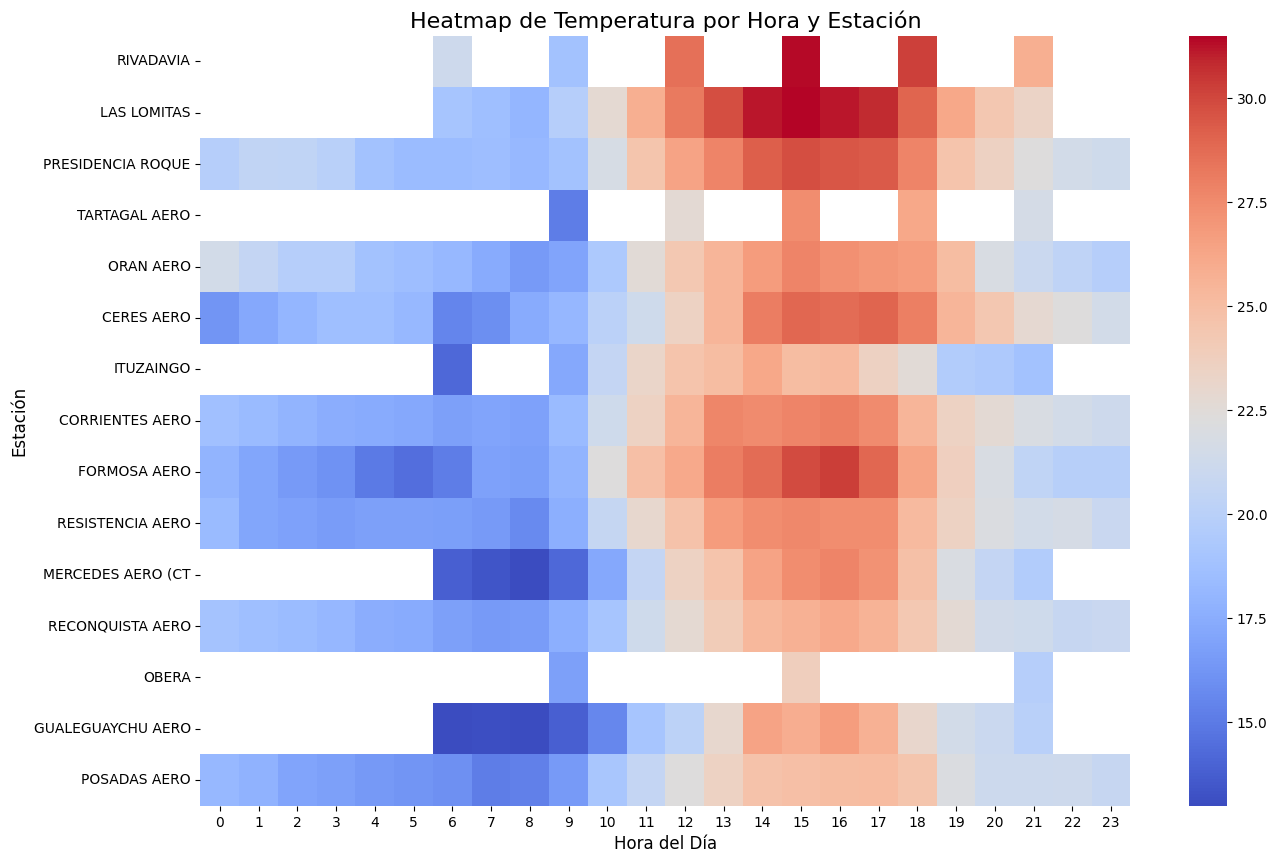

In [233]:
heatmap_data = df_combinado.pivot_table(index='ESTACION', columns='HORA', values='TEMP (°C)')

# Para que sea más legible, seleccionamos algunas estaciones o lo filtramos
# por ejemplo, las 15 estaciones con la temperatura media más alta.
estaciones_top = df_combinado.groupby('ESTACION')['TEMP (°C)'].mean().nlargest(15).index
heatmap_data_filtrada = heatmap_data.loc[estaciones_top]


# Convertimos <NA> a np.nan para evitar errores en el heatmap
heatmap_data_filtrada = heatmap_data_filtrada.astype(float)

# Creamos el heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_filtrada, cmap='coolwarm', annot=False) # annot=True si quieres ver los números
plt.title('Heatmap de Temperatura por Hora y Estación', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Estación', fontsize=12)
plt.show()

Un indicio de error en la determinación puede ser diferencia significativa entre valores consecutivos (con 1 h de dif), así que deberíamos generar esta variable secundaria nueva y analizar esos errores.


--- GeoDataFrame Creado (primeras filas) ---
  FECHA (ddmmyyyy)  HORA  TEMP (°C)  HUM (%)  PNM (hPa)  DD (g)  FF (km/h)  \
0       2025-07-15     0       13.7       88     1020.2      80         13   
1       2025-07-15     1       13.6       91     1019.6      80         11   
2       2025-07-15     2       13.4       91     1019.3      80         11   
3       2025-07-15     3       13.4       94     1018.7      80         13   
4       2025-07-15     4       13.7       91     1018.2      90          9   

          ESTACION        PROVINCIA  LAT_GRAD  LAT_MIN  LON_GRAD  LON_MIN  \
0  AEROPARQUE AERO  CAPITAL FEDERAL     -34.0     33.0     -58.0     25.0   
1  AEROPARQUE AERO  CAPITAL FEDERAL     -34.0     33.0     -58.0     25.0   
2  AEROPARQUE AERO  CAPITAL FEDERAL     -34.0     33.0     -58.0     25.0   
3  AEROPARQUE AERO  CAPITAL FEDERAL     -34.0     33.0     -58.0     25.0   
4  AEROPARQUE AERO  CAPITAL FEDERAL     -34.0     33.0     -58.0     25.0   

   ALTURA      NUM Nro

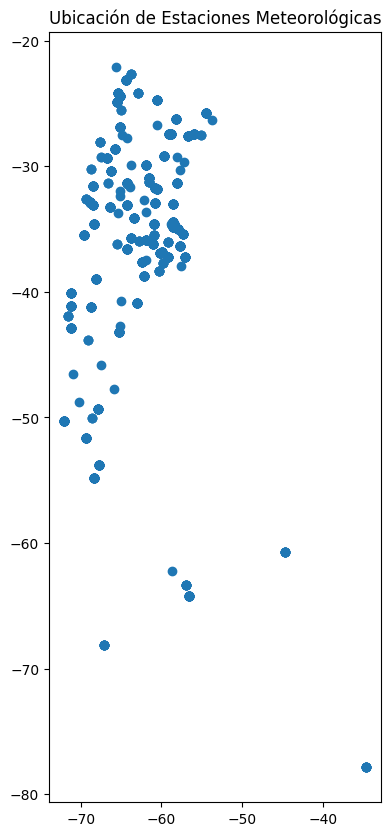

In [136]:
# Creamos el GeoDataFrame a partir del DataFrame combinado
# Especificamos que la geometría se crea a partir de las columnas 'lon' y 'lat'
gdf = gpd.GeoDataFrame(
    df_combinado,
    geometry=gpd.points_from_xy(df_combinado.LON, df_combinado.LAT),
    crs="EPSG:4326"  # CRS estándar para coordenadas lat/lon
)

print("\n--- GeoDataFrame Creado (primeras filas) ---")
print(gdf.head())

print("\nVisualizando las estaciones en un mapa...")
gdf.plot(figsize=(10, 10))
plt.title("Ubicación de Estaciones Meteorológicas")
plt.show()

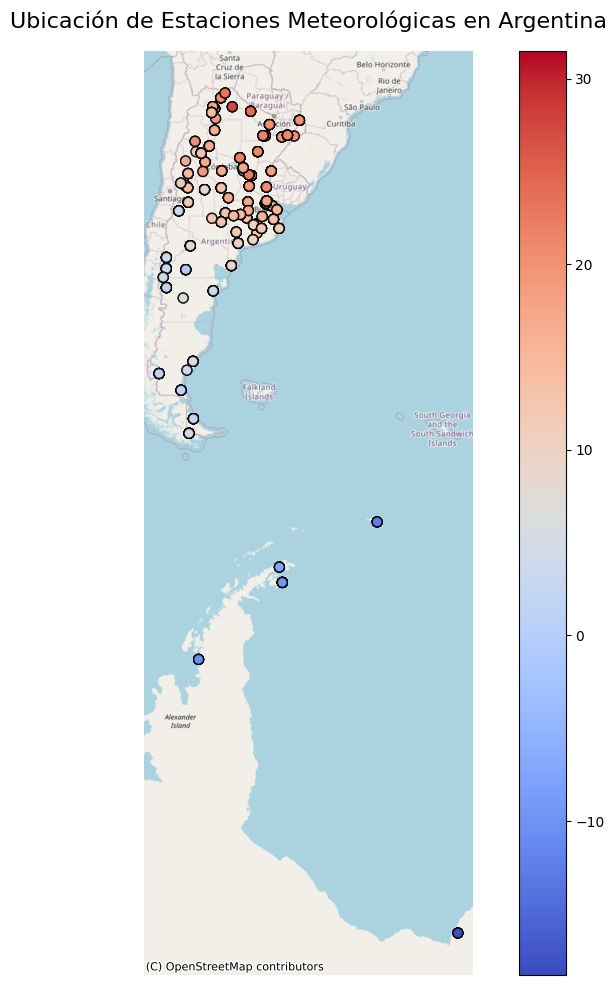

In [137]:
# 1. Reproyectar el GeoDataFrame al sistema de coordenadas de Web Mercator
gdf_wm = gdf.to_crs(epsg=3857)

# 2. Crear el gráfico de los puntos
fig, ax = plt.subplots(figsize=(12, 12))
gdf_wm.plot(ax=ax,
            column='TEMP (°C)',  # Columna para colorear los puntos por provincia
            cmap='coolwarm',  # Mapa de colores
            edgecolor='black',
            alpha=0.7,
            markersize=50,
            legend=True)

# 3. Añadir el mapa de fondo usando contextily
# Usaremos OpenStreetMap como fuente del mapa
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 4. Limpiar y mostrar el gráfico
ax.set_axis_off() # Ocultamos los ejes, ya no son necesarios
plt.title("Ubicación de Estaciones Meteorológicas en Argentina", fontsize=16)
plt.show()

--- DataFrame Agregado (una fila por estación) ---
            ESTACION        LAT        LON  TEMP_media
0    AEROPARQUE AERO -34.550000 -58.416667     15.2375
1          AZUL AERO -36.816667 -59.883333     10.9875
2  BAHIA BLANCA AERO -38.700000 -62.150000      12.625
3     BARILOCHE AERO -41.133333 -71.150000    4.654167
4   BASE BELGRANO II -77.866667 -34.616667      -17.55


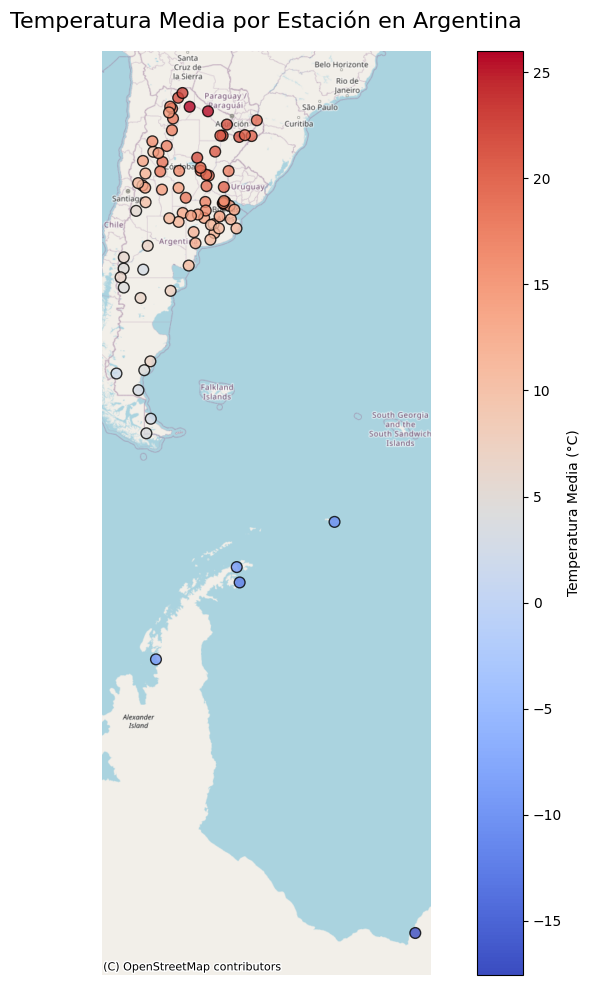

In [138]:
# Agrupamos por estación para tener UNA fila por estación.
# Calculamos la temperatura MEDIA para cada una.
df_agregado = df_combinado.groupby(['ESTACION', "LAT", "LON"]).agg(
    TEMP_media=('TEMP (°C)', 'mean')
).reset_index()

print("--- DataFrame Agregado (una fila por estación) ---")
print(df_agregado.head())


#CREAR EL GEODATAFRAME CON LOS DATOS AGREGADOS
gdf_agregado = gpd.GeoDataFrame(
    df_agregado,
    geometry=gpd.points_from_xy(df_agregado.LON, df_agregado.LAT),
    crs="EPSG:4326"
)


# GRAFICAR EL GEODATAFRAME ---
# Reproyectar al CRS correcto para el mapa base
gdf_agregado_wm = gdf_agregado.to_crs(epsg=3857)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar usando la nueva columna 'TEMP_media'
gdf_agregado_wm.plot(ax=ax,
                     column='TEMP_media', # <-- Usamos la nueva columna con el promedio
                     cmap='coolwarm',
                     legend=True,
                     legend_kwds={'label': "Temperatura Media (°C)"},
                     alpha=0.8,
                     markersize=60,
                     edgecolor='black')

# Añadir mapa de fondo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Temperatura Media por Estación en Argentina", fontsize=16)
plt.show()

In [139]:
import plotly.express as px

# Creamos la figura interactiva con una sola línea de código
fig = px.scatter_map(
    df_agregado,
    lat="LAT",
    lon="LON",
    color="TEMP_media",             
    hover_name="ESTACION",            # Muestra el nombre de la estación al pasar el mouse
    hover_data={'TEMP_media': ':.2f'}, # Info extra en el hover, con 2 decimales
    color_continuous_scale=px.colors.sequential.Plasma, # Paleta de colores
    zoom=3,                         # Nivel de zoom inicial
    center={"lat": -40, "lon": -64}, # Centra el mapa en Argentina
    title="Temperatura Media por Estación en Argentina"
)

fig.show()

Con los últimos gráficos quisimos ver si encontrábamos alguna tendencia entre valores atípicos en temperatura con correlación geoespacial, y también si tenían sentido los valores detectados.
Nos focalizamos en analizar la variable target, pero luego vimos que deberíamos haber analizado mejor las otras features dado que son las que deberíamos limpiar para poder luego entrenar un modelo.